In [1]:
from comp_overrule import learn_srules, learn_s_orules, get_overlap_violations
from comp_overrule_knn import learn_orules as learn_knnrules
from comp_overrule_clr import learn_orules as learn_clrrules

from comp_overrule import plt_cl_lit, plt_sem, get_sem_optim
from utils import rule_str, rules_stats, transcribe, recent_model, read_model
from comp_preprocessing import get_data, get_lbl

from comp_causalmodel import causal_eval, propensity_model, bootstrap_effects, placebo_effects

import numpy as np
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
import time

%load_ext autoreload
%autoreload 2

folder = '/home/victora/PositivityViolation/'

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

### Learn support rules

In [18]:
DATA_PATH = folder + 'data/fp_select1613900028_KE.csv'
DATA_PATH = folder + 'data/fp_select1613901270_ET.csv'
DATA_PATH = folder + 'data/fp_select1613905911_NG.csv'

DATA_PATH = folder + 'data/fp_et-2-select1621333412.csv'

In [19]:
results = learn_srules(logspace=10, data_path=DATA_PATH)

100%|██████████| 10/10 [00:00<00:00, 50351.79it/s]

100%|██████████| 10/10 [00:00<00:00, 62508.26it/s]

100%|██████████| 10/10 [00:00<00:00, 66576.25it/s]

100%|██████████| 10/10 [00:00<00:00, 63072.24it/s]

100%|██████████| 10/10 [00:00<00:00, 61230.72it/s]

100%|██████████| 10/10 [00:00<00:00, 72944.42it/s]

100%|██████████| 10/10 [00:00<00:00, 40920.04it/s]

100%|██████████| 10/10 [00:00<00:00, 69098.91it/s]

100%|██████████| 10/10 [00:00<00:00, 67324.30it/s]

100%|██████████| 10/10 [00:00<00:00, 198.20it/s]


In [20]:
LAMBDA_0 = np.logspace(-7, -0.1, 10)
LAMBDA_1 = np.logspace(-7, -0.1, 10)

i = 0
for lambda_0 in LAMBDA_0:
    for lambda_1 in LAMBDA_1:
        results[i][4] = lambda_0
        results[i][5] = lambda_1 
        i = i +1

(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:title={'center':'support estimator'}, xlabel='Number of Clauses', ylabel='Balanced accuracy'>)

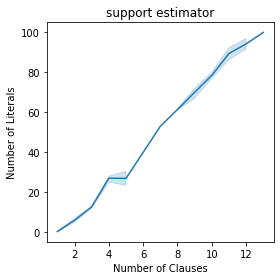

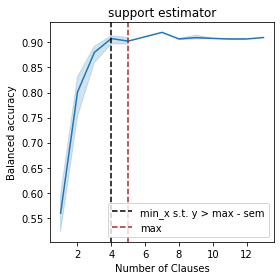

In [21]:
plt_cl_lit(results)
plt_sem(results)

In [22]:
optim = get_sem_optim(results, rtype='support')
print(optim)

0.9214626724725881
[(4, 28), None, 0.9129286676110033, None, 1e-07, 0.0006812920690579615]


In [23]:
from comp_overrule import overrulefit
X_df, a, y = get_data(DATA_PATH)

X_df = X_df[~y.isna()]
a = a[~y.isna()]
y = y[~y.isna()]
    
_, RS_s, _, auc, _ = overrulefit(X_df, a, LAMBDA0_s=optim[4], LAMBDA1_s=optim[5], only_support=True)

In [24]:
stats = rules_stats(RS_s.rules, X_df, a)
transcribe(stats, var_encoding_path=folder + 'data/varencoding-et.txt')

[['Region is not "Gambela" and',
  'Type of place of residence is  "Urban" and',
  'Type of place of residence is not "Rural" and',
  'Education in single years <= 13.5 and',
  'Unmet need is not "Unmet need for limiting"'],
 ['Region is not "Tigray" and',
  'Region is not "Addis Adaba" and',
  'Region is  "Gambela" and',
  'Heard family planning on newspaper/magazine last few months not  and',
  'Age at first sex <= 22.5 and',
  'Unmet need is not "Unmet need for limiting"'],
 ['Region is not "Addis Adaba" and',
  'Region is not "Gambela" and',
  'Type of place of residence is not "Urban" and',
  'Type of place of residence is  "Rural" and',
  'Highest educational level <= 2.5 and',
  'Education in single years <= 13.5 and',
  'Age at first sex <= 22.5'],
 ['Region is not "Addis Adaba" and',
  'Region is not "Gambela" and',
  'Type of place of residence is not "Urban" and',
  'Type of place of residence is  "Rural" and',
  'Highest educational level <= 2.5 and',
  'Education in single

In [25]:
auc

0.9129286676110033

### Learn overlap rules

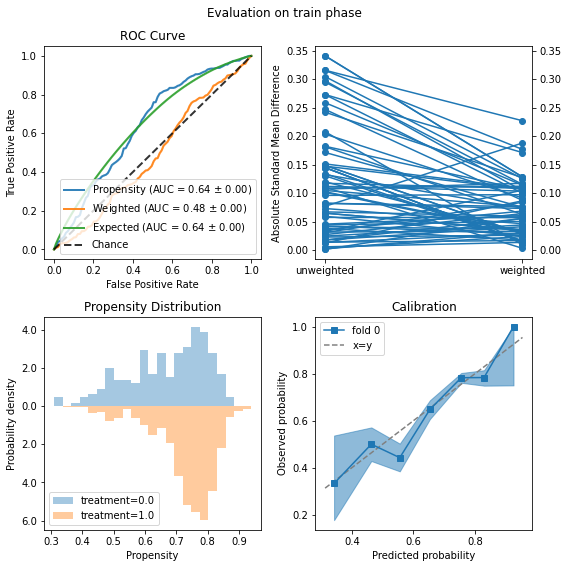

In [26]:
from comp_overrule_clr import model
from utils import write_model

evaluations, X_test, a_test, y_test = propensity_model(DATA_PATH)
bestmodel = evaluations.models.learner.steps[1][1].best_estimator_
write_model(bestmodel, 'clrmodel')

In [39]:
optim[4], optim[5]

(1e-07, 0.0006812920690579615)

In [ ]:
clr_results = learn_clrrules(LAMBDA0_s=optim[4], LAMBDA1_s=optim[5], logspace=2, data_path=DATA_PATH)

100%|██████████| 2/2 [00:00<00:00, 4230.26it/s]

100%|██████████| 2/2 [00:00<00:00, 44.07it/s]


In [ ]:
clr_results

In [ ]:
plt_cl_lit(clr_results, rtype='overlap')
plt_sem(clr_results, rtype='overlap')

In [32]:
LAMBDA_0 = np.logspace(-7, -0.1, 10)
LAMBDA_1 = np.logspace(-7, -0.1, 10)

i = 0
for lambda_0 in LAMBDA_0:
    for lambda_1 in LAMBDA_1:
        clr_results[i][4] = lambda_0
        clr_results[i][5] = lambda_1 
        i = i +1

optim_clr = get_sem_optim(clr_results, rtype='overlap')
print(optim_clr)

0.9560117302052786
[(3, 17), (6, 18), 0.9451723268842926, 0.9482804585443881, 5.843414133735175e-07, 1e-07]


In [34]:
knn_results = learn_knnrules(LAMBDA0_s=optim[4], LAMBDA1_s=optim[5], logspace=10, data_path=DATA_PATH, kmodel=read_model(folder + '/pickle/knnmodel_1613996894_ET.pickle'))

100%|██████████| 10/10 [00:00<00:00, 470.64it/s]

100%|██████████| 10/10 [00:00<00:00, 4654.13it/s]

100%|██████████| 10/10 [00:00<00:00, 4530.46it/s]

100%|██████████| 10/10 [00:00<00:00, 17098.67it/s]

100%|██████████| 10/10 [00:00<00:00, 19887.64it/s]

100%|██████████| 10/10 [00:00<00:00, 25637.56it/s]

100%|██████████| 10/10 [00:00<00:00, 10491.01it/s]

100%|██████████| 10/10 [00:00<00:00, 21345.06it/s]

100%|██████████| 10/10 [00:00<00:00, 87.71it/s]


(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f965e4d1e48>)

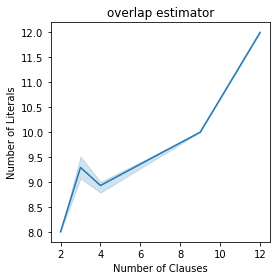

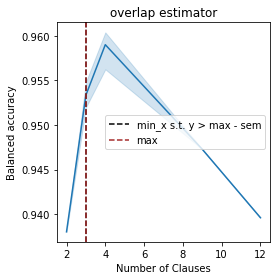

In [35]:
plt_cl_lit(knn_results, rtype='overlap')
plt_sem(knn_results, rtype='overlap')

In [36]:
LAMBDA_0 = np.logspace(-7, -0.1, 10)
LAMBDA_1 = np.logspace(-7, -0.1, 10)

i = 0
for lambda_0 in LAMBDA_0:
    for lambda_1 in LAMBDA_1:
        knn_results[i][4] = lambda_0
        knn_results[i][5] = lambda_1 
        i = i +1

optim_knn = get_sem_optim(knn_results, rtype='overlap')
print(optim_knn)

0.9672847682119206
[(3, 17), (3, 11), 0.9451723268842926, 0.9672847682119206, 0.1359356390878527, 0.0006812920690579615]


### Combined ruleset estimator

In [37]:
modelpath = folder + recent_model('clrmodel')
modelpath = '/home/victora/PositivityViolation/pickle/clrmodel_1613985796_ET.pickle'

X_df, a, y = get_data(DATA_PATH)
len(X_df)

3784

In [38]:
M, RS_s, RS_o, auc, score_base = learn_s_orules(modelpath, optim[4], optim[5], optim_clr[4], optim_clr[5], data_path=DATA_PATH)

In [39]:
stats = rules_stats(RS_s.rules, X_df, a)
transcribe(stats, var_encoding_path=folder + 'data/varencoding-et.txt')

[['Region is not "Dire Dawa" and',
  'Type of place of residence is  "Urban" and',
  'Type of place of residence is not "Rural" and',
  'Total children ever born <= 8.5 and',
  'Pattern of use is not "Used before last birth"'],
 ['Region is not "Addis Adaba" and',
  'Region is not "Dire Dawa" and',
  'Region is not "Harari" and',
  'Type of place of residence is not "Urban" and',
  'Type of place of residence is  "Rural"'],
 ['Region is not "Addis Adaba" and',
  'Region is  "Dire Dawa" and',
  'Region is not "Gambela" and',
  'Region is not "Harari" and',
  'Total children ever born <= 8.5 and',
  'Pattern of use is not "Used before last birth" and',
  'Exposure is not "Infecund, menopausal"']]

In [40]:
stats = rules_stats(RS_o.rules, X_df, a)
transcribe(stats, var_encoding_path=folder + 'data/varencoding-et.txt')

[['Unmet need is  "No unmet need"'],
 ['Education in single years <= 12.0 and',
  'Region is not "Harari" and',
  'Visited health facility last 12 months is not "Yes" and',
  'Exposure is not "Pregnant" and',
  'Unmet need is not "Infecund, menopausal"'],
 ['Knowledge of ovulatory cycle is not "During her period" and',
  'Unmet need is  "Using for limiting" and',
  'Time since last menstrual period <= 995.0'],
 ['Education in single years <= 7.0 and',
  'Region is not "Gambela" and',
  'Unmet need is  "Using for spacing"'],
 ['Highest educational level > 1.0 and',
  'Frequency of reading newspaper or magazine <= 1.0 and',
  'Currently/formerly/never in union is  "Currently in union/living with a man"'],
 ['Frequency of listening to radio <= 0.0 and',
  'Unmet need is not "Unmet need for spacing" and',
  'Time since last menstrual period <= 338.0']]

In [41]:
overlap_index_clr, violating_index_clr = get_overlap_violations(RS_s, RS_o, data_path=DATA_PATH)

In [42]:
import pandas as pd
overlap_Xdf = X_df.loc[~X_df.index.isin(violating_index_clr)]
overlap_adf = a.loc[~X_df.index.isin(violating_index_clr)]
overlap_ydf = y.loc[~X_df.index.isin(violating_index_clr)]

concat_df = pd.concat((overlap_Xdf, overlap_adf, overlap_ydf), axis=1)

In [43]:
print(len(concat_df)/len(X_df))
concat_df.to_csv(folder + '/data/overlap_et-clr.csv', index=False)

0.8887420718816068


In [ ]:
modelpath = folder + recent_model('knnmodel')

In [45]:
modelpath = '/home/victora/PositivityViolation/pickle/knnmodel_1613996894_ET.pickle'
M, RS_s, RS_o, auc, score_base = learn_s_orules(modelpath, optim[4], optim[5], optim_knn[4], optim_knn[5], data_path=DATA_PATH)

In [46]:
stats = rules_stats(RS_o.rules, X_df, a)
transcribe(stats, var_encoding_path=folder + 'data/varencoding-et.txt')

[['Desire for more children is not "Wants within 2 years" and',
  'Exposure is not "Infecund, menopausal" and',
  'Unmet need is not "Unmet need for spacing"'],
 ['Region is not "Gambela" and',
  'Region is not "Addis Adaba" and',
  'Literacy is not "No card with required language" and',
  'Desire for more children is not "Wants, unsure timing" and',
  'Births in past year <= 0.0'],
 ['Region is not "Oromia" and',
  'Literacy is not "No card with required language" and',
  'Heard family planning on radio last few months not ']]

In [47]:
overlap_index_knn, violating_index_knn = get_overlap_violations(RS_s, RS_o, data_path=DATA_PATH)

In [48]:
import pandas as pd
overlap_Xdf = X_df.loc[~X_df.index.isin(violating_index_knn)]
overlap_adf = a.loc[~X_df.index.isin(violating_index_knn)]
overlap_ydf = y.loc[~X_df.index.isin(violating_index_knn)]

concat_df = pd.concat((overlap_Xdf, overlap_adf, overlap_ydf), axis=1)

print(len(concat_df)/len(X_df))
concat_df.to_csv(folder + '/data/overlap_et-knn.csv', index=False)

0.9323467230443975


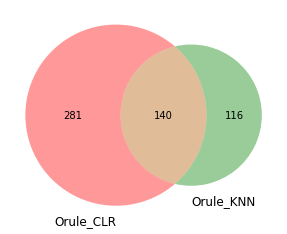

In [49]:
set1 = set(violating_index_clr)
set2 = set(violating_index_knn)

fig, ax = plt.subplots()
venn2([set1, set2], ('Orule_CLR', 'Orule_KNN'), ax=ax)

In [50]:
timestamp = str(int(time.time()))
fig.savefig(folder + 'figures/venn2' + timestamp + '.pdf')